## Venues Finder

During the second project by The Lion's Den, we tasked ourselves to determine if dispensaries caused an increase in crime over time within the city of Los Angeles. To continue on with our dispenary journey, we wanted to look at building a machine learning model to help us determine where to put potential locations for other cities.  This model will be based against LA and we will use both census data and venue types by zipcode.

#### Data:
- Census data is being gathered from the National Census Bureau using api calls. This was pulled and saved in another notebook (this-repo/etl/ETL_Notebooks/ETL.ipynb)
- Venue data is being gathered from FourSquare using api calls.  This can be found below.


 
This was inspired by https://github.com/ejmacias/Store_Locations/blob/main/store_locations.ipynb where the original author was trying to determine where in Madrid to place low-cost supermarkets.

## We will start by importing needed libraries

In [1]:
import requests  
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import seaborn as sns

In [2]:
# Get api keys from key file
from api_keys import client_id, client_secret

ModuleNotFoundError: No module named 'api_keys'

## Next create a dataframe by Zip Codes

In [3]:
zipCSVPath = '../../data/Zip_Code_Data.csv'
zipDF = pd.read_csv(zipCSVPath)
zipDF['Zip'] = zipDF['Zip'].astype(str)
zipDF.head()

,Zip,LAT,LNG,Num_Disp,City,Total_Pop,Percent_Under_18_Years,Percent_Ages_18_to_24,Percent_18_and_Older,Percent_21_and_Older,...,Pct_Female,Females_Median_Age,Total_Households,Households_with_Children,Pct_Households_with_Children,Pct_Owner_Occupied,Pct_Renter_Occupied,Household_Median_Income,Household_Median_Inc_Quintiles,Pct_Earned_Income_Past_12_Months
0,90021,34.030124,-118.241779,44.0,Los Angeles,2945,11.3,5.7,88.7,86.8,...,38.4,35.2,1734,171,9.9,9.0,91.0,21635,Quintile 1,25.4
1,90058,34.001842,-118.221127,9.0,Los Angeles,2718,41.1,10.4,58.9,53.1,...,58.1,25.3,706,336,47.6,12.0,88.0,21964,Quintile 1,40.9
2,90013,34.046022,-118.246250,2.0,Los Angeles,12559,3.2,5.5,96.8,96.1,...,36.5,40.6,7308,256,3.5,7.8,92.2,22316,Quintile 1,20.2
3,90007,34.028334,-118.285077,4.0,Los Angeles,42433,14.2,38.3,85.8,69.4,...,48.4,25.1,11919,2213,18.6,12.3,87.7,27406,Quintile 1,41.6
4,90037,34.003494,-118.287097,1.0,Los Angeles,67640,27.8,11.0,72.2,67.8,...,49.8,32.2,17699,6455,36.5,24.1,75.9,35424,Quintile 1,51.4


### Create dataframe for LA zip/census data only

In [4]:
laDF = zipDF[(zipDF.City=="Los Angeles")]

print(laDF.shape)
laDF.head()
#laDF.dtypes

(123, 25)


,Zip,LAT,LNG,Num_Disp,City,Total_Pop,Percent_Under_18_Years,Percent_Ages_18_to_24,Percent_18_and_Older,Percent_21_and_Older,...,Pct_Female,Females_Median_Age,Total_Households,Households_with_Children,Pct_Households_with_Children,Pct_Owner_Occupied,Pct_Renter_Occupied,Household_Median_Income,Household_Median_Inc_Quintiles,Pct_Earned_Income_Past_12_Months
0,90021,34.030124,-118.241779,44.0,Los Angeles,2945,11.3,5.7,88.7,86.8,...,38.4,35.2,1734,171,9.9,9.0,91.0,21635,Quintile 1,25.4
1,90058,34.001842,-118.221127,9.0,Los Angeles,2718,41.1,10.4,58.9,53.1,...,58.1,25.3,706,336,47.6,12.0,88.0,21964,Quintile 1,40.9
2,90013,34.046022,-118.246250,2.0,Los Angeles,12559,3.2,5.5,96.8,96.1,...,36.5,40.6,7308,256,3.5,7.8,92.2,22316,Quintile 1,20.2
3,90007,34.028334,-118.285077,4.0,Los Angeles,42433,14.2,38.3,85.8,69.4,...,48.4,25.1,11919,2213,18.6,12.3,87.7,27406,Quintile 1,41.6
4,90037,34.003494,-118.287097,1.0,Los Angeles,67640,27.8,11.0,72.2,67.8,...,49.8,32.2,17699,6455,36.5,24.1,75.9,35424,Quintile 1,51.4


In [5]:
# borrowed this check from the madrid study.  I like this...
laDF.isnull().sum()

Zip                                 0
LAT                                 0
LNG                                 0
Num_Disp                            0
City                                0
Total_Pop                           0
Percent_Under_18_Years              0
Percent_Ages_18_to_24               0
Percent_18_and_Older                0
Percent_21_and_Older                0
Percent_60_and_Older                0
Number_Males                        0
Percent_Male                        0
Male_Median_Age                     0
Number_Females                      0
Pct_Female                          0
Females_Median_Age                  0
Total_Households                    0
Households_with_Children            0
Pct_Households_with_Children        0
Pct_Owner_Occupied                  0
Pct_Renter_Occupied                 0
Household_Median_Income             0
Household_Median_Inc_Quintiles      0
Pct_Earned_Income_Past_12_Months    0
dtype: int64

#### Limit the columns for the final dataset

In [7]:
laDFTarget = laDF[['Zip', 
                   'City', 
                   'LAT', 
                   'LNG', 
                   "Num_Disp",
                   'Total_Pop',
                   'Total_Households', 
                   'Household_Median_Income',
                   'Percent_21_and_Older',
                   'Percent_60_and_Older',
                   'Percent_Male',
                   'Pct_Owner_Occupied',
                   'Pct_Renter_Occupied'
                  ]]

### Create dataframe for Sacramento zip/census data only

In [8]:
sacDF = zipDF[zipDF.City=="Sacramento"]

sacDF.head()

,Zip,LAT,LNG,Num_Disp,City,Total_Pop,Percent_Under_18_Years,Percent_Ages_18_to_24,Percent_18_and_Older,Percent_21_and_Older,...,Pct_Female,Females_Median_Age,Total_Households,Households_with_Children,Pct_Households_with_Children,Pct_Owner_Occupied,Pct_Renter_Occupied,Household_Median_Income,Household_Median_Inc_Quintiles,Pct_Earned_Income_Past_12_Months
123,95814,38.58167,-121.49591,1.0,Sacramento,11908,6.5,10.2,93.5,92.0,...,42.1,33.6,6709,446,6.6,7.2,92.8,33938,Quintile 1,21.6
124,95815,38.60570,-121.44588,4.0,Sacramento,25673,27.0,10.2,73.0,69.2,...,48.5,33,9226,2749,29.8,33.7,66.3,34583,Quintile 1,31.4
125,95824,38.51773,-121.44093,0.0,Sacramento,30296,28.6,11.1,71.4,67.1,...,50.2,34.2,9103,3627,39.8,39.5,60.5,38985,Quintile 1,40.0
126,95832,38.44796,-121.49676,0.0,Sacramento,12114,29.6,12.1,70.4,65.5,...,49.3,31,3147,1257,39.9,49.3,50.7,47341,Quintile 1,38.4
127,95823,38.47424,-121.44310,0.0,Sacramento,79440,29.4,9.2,70.6,67.3,...,51.4,32,23710,9088,38.3,45.7,54.3,47553,Quintile 2,38.9


In [9]:
# borrowed this check from the madrid study.  I like this...
sacDF.isnull().sum()

Zip                                 0
LAT                                 0
LNG                                 0
Num_Disp                            0
City                                0
Total_Pop                           0
Percent_Under_18_Years              0
Percent_Ages_18_to_24               0
Percent_18_and_Older                0
Percent_21_and_Older                0
Percent_60_and_Older                0
Number_Males                        0
Percent_Male                        0
Male_Median_Age                     0
Number_Females                      0
Pct_Female                          0
Females_Median_Age                  0
Total_Households                    0
Households_with_Children            0
Pct_Households_with_Children        0
Pct_Owner_Occupied                  0
Pct_Renter_Occupied                 0
Household_Median_Income             0
Household_Median_Inc_Quintiles      0
Pct_Earned_Income_Past_12_Months    0
dtype: int64

#### Limit the columns for the final dataset

In [10]:
sacDFTarget = sacDF[['Zip', 
                   'City', 
                   'LAT', 
                   'LNG', 
                   "Num_Disp",
                   'Total_Pop',
                   'Total_Households', 
                   'Household_Median_Income',
                   'Percent_21_and_Older',
                   'Percent_60_and_Older',
                   'Percent_Male',
                   'Pct_Owner_Occupied',
                   'Pct_Renter_Occupied'
                  ]]

## Define method to get venues by the lat and long

In [ ]:
clientID = client_id # Foursquare ID
clientSecret = client_secret # Foursquare Secret
version = '20210830' # Foursquare API version
limit = 100 # A default Foursquare API limit value

In [ ]:
# Function to find venues in a given neighbourhood
def getVenues(zipCode, latitudes, longitudes, radius=1000):
    
    cols = ['Zip','Zip Latitude','Zip Longitude','Venue','Venue Latitude','Venue Longitude','Venue Category']
    venuesList=[]
            
    for zipC, lat, lng in zip(zipCode, latitudes, longitudes):
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/search?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            clientID
            ,clientSecret
            ,version
            ,lat
            ,lng
            ,radius
            ,limit)

        # make the GET request
        results = requests.get(url).json()["response"]["venues"]
 #       print(results)
        
        # return only relevant information for each nearby venue
        venuesList.append([(
            zipC,
            lat, 
            lng, 
            v['name'], 
            v['location']['lat'], 
            v['location']['lng'],  
            v['categories'][0]['name']) for v in results if v['categories']])

    nearbyVenues = pd.DataFrame([item for venuesList in venuesList for item in venuesList])
    nearbyVenues.columns = cols
    
    return(nearbyVenues)

#### Uncomment either cell below to either get a new set of data or reuse saved data.  This is to keep api calls down.

In [11]:
laVenueCSV = '../../data/la_venues.csv'

In [12]:
# #### UNCOMMENT THE FOLLOWING FOR A NEW RUN
# # Search for venues within 1Km of radius from the lat and lng
# radius = 100

# laVenuesDF = getVenues(laDFTarget['Zip'],laDFTarget['LAT'],laDFTarget['LNG'],radius)

# # Write out la venue df to csv
# laVenuesDF.to_csv(laVenueCSV)  #write out venues

# laVenuesDF.head()

In [13]:
# Load la venues dataframe from saved file
laVenuesDF = pd.read_csv(laVenueCSV)
print(laVenuesDF.shape)

laVenuesDF.head(1000)

(10237, 8)


,Unnamed: 0,Zip,Zip Latitude,Zip Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,90021,34.030124,-118.241779,Joker Party Supply,34.030060,-118.242230,Miscellaneous Shop
1,1,90021,34.030124,-118.241779,Los Angeles Wholesale Produce Market,34.031842,-118.242101,Farmers Market
2,2,90021,34.030124,-118.241779,Davalan Sales,34.030091,-118.241833,Food
3,3,90021,34.030124,-118.241779,american celebrations party supplies,34.029739,-118.241905,Arts & Crafts Store
4,4,90021,34.030124,-118.241779,Avina's Tacos,34.030337,-118.242077,Taco Place
...,...,...,...,...,...,...,...,...
995,995,90003,33.963350,-118.273936,CCC Leadership & Business Training Center (L.B...,33.957903,-118.278627,Non-Profit
996,996,90003,33.963350,-118.273936,$1 Tacos,33.968070,-118.278228,Food Truck
997,997,90003,33.963350,-118.273936,Western Truck Exchange,33.960480,-118.271866,Automotive Shop
998,998,90003,33.963350,-118.273936,El Tacorian,33.964539,-118.278740,Taco Place


In [14]:
# Pivot the Venue Category column for each lat and long
pivotedLaDF = pd.get_dummies(laVenuesDF[['Venue Category']],prefix="",prefix_sep="")

pivotedLaDF.head(1000)

,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,Airport Terminal,...,Wedding Hall,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# add zip to pivoted dataframe
pivotedLaDF['Zip'] = laVenuesDF['Zip'].astype(str)

# move zip to the first column of the pivoted dataframe
orderedCols = [pivotedLaDF.columns[-1]] + list(pivotedLaDF.columns[:-1])
pivotedLaDF = pivotedLaDF[orderedCols]

In [16]:
print(pivotedLaDF.shape)
pivotedLaDF.head(1000) # sanity check

(10237, 502)


,Zip,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Wedding Hall,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,90021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,90021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,90021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,90021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,90021,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,90003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,90003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,90003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,90003,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
laGrouped = pivotedLaDF.groupby('Zip').mean().reset_index()

print(laGrouped.shape)
laGrouped.head(1000)

(123, 502)


,Zip,ATM,Accessories Store,Acupuncturist,Adult Boutique,Adult Education Center,Advertising Agency,Afghan Restaurant,African Restaurant,Airport,...,Wedding Hall,Weight Loss Center,Whisky Bar,Wine Bar,Wine Shop,Winery,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,90001,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.011494,0.0,0.034483,0.0,0.0,0.0,0.000000,0.000000,0.0
1,90002,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.010870,0.0,0.0,0.0,0.010870,0.000000,0.0
2,90003,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.021053,0.0,0.0,0.0,0.000000,0.000000,0.0
3,90004,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.010989,0.000000,0.0
4,90005,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.142857,0.0,0.0,0.0,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,91602,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.011628,0.0
119,91604,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0
120,91605,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.011628,0.0,0.0,0.0,0.000000,0.011628,0.0
121,91606,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.0


## Find the most common venues for each LA zip
We have decided to cluster based on the top 5 most types of venues based on the mean counts.  This took some experimenting with large and smaller values and seeing the results.

In [ ]:
# Function for sorting the venues in descending order
def getMostCommonVenues(row, numTopVenues):
    rowCategories = row.iloc[1:]
    rowCategoriesSrt = rowCategories.sort_values(ascending=False)
    
    return rowCategoriesSrt.index.values[0:numTopVenues]

In [ ]:
# Creates the dataframe with the top n common venues
numTopVenues = 5

indicators = ['st', 'nd', 'rd'] #suffix for the numeric position

# create columns according to number of top venues
columns = ['Zip']
for ind in np.arange(numTopVenues):
    try:
        columns.append('{}{}'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th'.format(ind+1))

# create a new dataframe
laVenuesSrt = pd.DataFrame(columns=columns)
laVenuesSrt['Zip'] = laGrouped['Zip']

for ind in np.arange(laGrouped.shape[0]):
    laVenuesSrt.iloc[ind, 1:] = getMostCommonVenues(laGrouped.iloc[ind, :], numTopVenues)

print(laVenuesSrt.shape)
laVenuesSrt.head()

## ML TIME
Adding KMeans Clustering to group venues.

Text(0.5, 1.0, 'Elbow Method For Clusters')

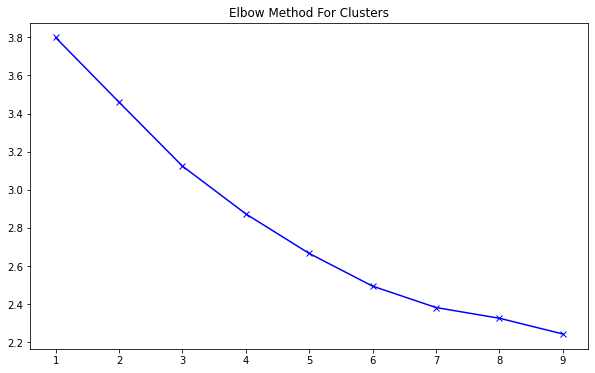

In [18]:
# Find number of clusters using the elbow method
laClustering = laGrouped.drop('Zip', 1)
ssd = []
K = range(1,10)

for k in K:
    kmeans = KMeans(
                n_clusters=k, 
                random_state=100,
                n_init=10,
                max_iter=300)
    
    kmeans.fit(laClustering)
    ssd.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(K, ssd, 'bx-')
plt.title('Elbow Method For Clusters')

In [20]:
# Number of clusters
ks = 4

# Run Kmeans
kmeans = KMeans(n_clusters=ks).fit(laClustering)

In [21]:
# check cluster labels generated for each row in the dataframe
kmeans.labels_

array([1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 3, 1, 1, 3,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 2, 1, 1, 0,
       0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 1, 1, 1, 1, 0,
       1, 1, 2, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1,
       2, 0, 0, 1, 2, 1, 1, 3, 0, 1, 1, 1, 1])

In [22]:
# view cluster centers
kmeans.cluster_centers_

array([[ 8.67361738e-19, -2.16840434e-19, -6.50521303e-19, ...,
         7.84313725e-04,  7.75193798e-04, -2.71050543e-20],
       [ 2.38257685e-03,  8.43283357e-04,  1.71787784e-03, ...,
         3.53990196e-03,  2.25370248e-03,  1.18371212e-04],
       [ 0.00000000e+00,  1.87265918e-03,  5.84091314e-03, ...,
         0.00000000e+00,  4.33680869e-19,  0.00000000e+00],
       [ 0.00000000e+00,  0.00000000e+00, -2.16840434e-19, ...,
         2.00803213e-03,  2.13675214e-03,  0.00000000e+00]])

In [23]:
# add cluster labels
laVenuesSrt.insert(1, 'Cluster_Labels', kmeans.labels_)

laVenuesSrt.head()

NameError: name 'laVenuesSrt' is not defined

In [24]:
laVenuesSrt.loc[laVenuesSrt['Cluster_Labels'] == 0, laVenuesSrt.columns[[0] + [1] + list(range(2, laVenuesSrt.shape[1]))]]

# Medical

NameError: name 'laVenuesSrt' is not defined

In [25]:
laVenuesSrt.loc[laVenuesSrt['Cluster_Labels'] == 1, laVenuesSrt.columns[[0] + [1] + list(range(2, laVenuesSrt.shape[1]))]]

# Business, Shopping

NameError: name 'laVenuesSrt' is not defined

In [26]:
laVenuesSrt.loc[laVenuesSrt['Cluster_Labels'] == 2, laVenuesSrt.columns[[0] + [1] + list(range(2, laVenuesSrt.shape[1]))]]

# Shopping areas


NameError: name 'laVenuesSrt' is not defined

In [27]:
laVenuesSrt.loc[laVenuesSrt['Cluster_Labels'] == 3, laVenuesSrt.columns[[0] + [1] + list(range(2, laVenuesSrt.shape[1]))]]

# Residential, shopping

NameError: name 'laVenuesSrt' is not defined

In [28]:
laDFMerged = laDFTarget
laVenuesTarget = laVenuesSrt[['Zip','Cluster_Labels']]

# merge madrid_grouped with df_madrid to add latitude/longitude for each neighbourhood
laDFMerged = laVenuesTarget.join(laDFMerged.set_index('Zip'), on='Zip')

laDFMerged.head()

NameError: name 'laVenuesSrt' is not defined

In [ ]:
laCombinedCSV = '../../data/la_combined.csv'

laDFMerged.to_csv(laCombinedCSV)